## Importing Python Packages

In [111]:
from sklearn.cluster import KMeans
from pandas.io.json import json_normalize

import folium
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns

## Set Foursquare API Credentials

In [99]:
CLIENT_ID = 'UBIHL11MMQA3KOOEVUEMNVQKXX15P3Y0NBNYEH0B15AKDM33' # your Foursquare ID
CLIENT_SECRET = 'CMC1HQKZVYZ5O3JRURIADE4LGMH4IMMEULQXWL31JB1XPRMV' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

## Importing NYC Neighbourhood Name And Location

In [101]:
with open('nyu-2451-34572-geojson (1).json') as json_data:
    newyork_data = json.load(json_data)
nyc_neighborhood_data = newyork_data['features']
nyc_neighborhood_data[2]

{'type': 'Feature',
 'id': 'nyu_2451_34572.3',
 'geometry': {'type': 'Point',
  'coordinates': [-73.82780644716412, 40.887555677350775]},
 'geometry_name': 'geom',
 'properties': {'name': 'Eastchester',
  'stacked': 1,
  'annoline1': 'Eastchester',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.82780644716412,
   40.887555677350775,
   -73.82780644716412,
   40.887555677350775]}}

In [104]:
column_names = ['Borough','Neighborhood','Latitude','Longitude']

nyc_neighborhoods = pd.DataFrame(columns=column_names)

for data in nyc_neighborhood_data:
    borough = nyc_neighborhood_data = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    nyc_neighborhoods = nyc_neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
nyc_neighborhoods.head(5)

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


## Retrive Nighlife related venue data from foursquare
Beach Bar : '4bf58dd8d48988d116941735' <br>
Beer Bar : 56aa371ce4b08b9a8d57356c <br>
Beer Garden : 4bf58dd8d48988d117941735 <br>
Champagne Bar : 52e81612bcbc57f1066b7a0e <br>
Cocktail Bar : 4bf58dd8d48988d11e941735 <br>
Dive Bar : 4bf58dd8d48988d118941735 <br>
Hookah Bar : 4bf58dd8d48988d119941735 <br>
Karaoke Bar : 4bf58dd8d48988d120941735 <br>
Sports Bar : 4bf58dd8d48988d11d941735 <br>
Whisky Bar : 4bf58dd8d48988d122941735 <br>
Wine Bar : 4bf58dd8d48988d123941735 <br>
Brewery : 50327c8591d4c4b30a586d5d <br>
Lounge : 4bf58dd8d48988d121941735 <br>
Night Market : 53e510b7498ebcb1801b55d4 <br>
Nightclub : 4bf58dd8d48988d11f941735 <br>
Other Nightlife : 4bf58dd8d48988d11a941735 <br>
Strip Club : 4bf58dd8d48988d1d6941735 <br>

### Function to create api url

In [105]:
def createURL(endpoint, CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, categoryId, limit):
    url = '{}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
            endpoint,
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            categoryId,
            limit
        )
    return url

endpoint = 'https://api.foursquare.com/v2/venues/search?'
categoryIds = ['4bf58dd8d48988d116941735', '56aa371ce4b08b9a8d57356c', '4bf58dd8d48988d117941735',
               '52e81612bcbc57f1066b7a0e', '4bf58dd8d48988d11e941735', '4bf58dd8d48988d118941735',
               '4bf58dd8d48988d119941735', '4bf58dd8d48988d120941735', '4bf58dd8d48988d11d941735',
               '4bf58dd8d48988d122941735', '4bf58dd8d48988d123941735','50327c8591d4c4b30a586d5d',
               '4bf58dd8d48988d121941735','53e510b7498ebcb1801b55d4','4bf58dd8d48988d11f941735',
               '4bf58dd8d48988d11a941735','4bf58dd8d48988d1d6941735'
              ]
categoryId = ','.join(categoryIds)
limit = 50

### function to retrieve all nightlife related venues per neighborhood

In [106]:
def getNearbyNightlifeVenues(neighborhoods, latitudes, longitudes, radius=1000):
    endpoint = 'https://api.foursquare.com/v2/venues/search?'
    
    venues_list = []
    
    for hood_name, lat, lng in zip(neighborhoods, latitudes, longitudes):
    
        url = createURL(endpoint, CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, categoryId, limit)
        
        results = requests.get(url).json()['response']['venues']

        for item in results:
            venue_name = item['name']
            venue_category = item['categories'][0]['name']
            venue_lat = item['location']['lat']
            venue_lng = item['location']['lng']
            try:
                venue_city = item['location']['city']
            except:
                venue_city = 'N/A'
            venue_state = item['location']['state']
            
            venues_list.append([(hood_name,
                                lat,
                                lng,
                                venue_name,
                                venue_category,
                                venue_lat,
                                venue_lng,
                                venue_city,
                                venue_state
                               )])
            
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                             'Neighborhood Latitude',
                             'Neighborhood Longitude',
                             'Venue Name',
                             'Venue Category',
                             'Venue Latitude',
                             'Venue Longitude',
                             'Venue City',
                             'Venue State'
                            ]
    return nearby_venues

prelim_venue_data = getNearbyNightlifeVenues(nyc_neighborhoods['Neighborhood'],
                                         nyc_neighborhoods['Latitude'],
                                         nyc_neighborhoods['Longitude'],
                                         radius
                                        )

In [107]:
prelim_venue_data.shape

(15238, 9)

### Saving Dataframe as csv

In [108]:
prelim_venue_data.to_csv(path_or_buf='prelim_venue_data.csv')

In [109]:
prelim_venue_data = pd.read_csv('prelim_venue_data.csv', index_col=0)
prelim_venue_data.head(5)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Name,Venue Category,Venue Latitude,Venue Longitude,Venue City,Venue State
0,Wakefield,40.894705,-73.847201,Last Stop Bar,Bar,40.902410,-73.851398,Bronx,NY
1,Wakefield,40.894705,-73.847201,The Spot,Lounge,40.915285,-73.837481,Mount Vernon,NY
2,Wakefield,40.894705,-73.847201,Dragonsvale,Lounge,40.855817,-73.857473,Bronx,NY
3,Wakefield,40.894705,-73.847201,tavern 32,Bar,40.941408,-73.837414,Bronxville,NY
4,Wakefield,40.894705,-73.847201,Tilila,Bar,40.883872,-73.898209,Bronx,NY


## Exploratory Data Analysis

### States that have targeted venues

In [110]:
prelim_venue_data.groupby('Venue State')['Venue State'].count()

Venue State
NJ              648
NY            14328
New Jersey       26
New York        236
Name: Venue State, dtype: int64

###  Venue categories 

In [112]:
n_unique = len(prelim_venue_data['Venue Category'].unique())
print(f'There are {n_unique} unique venue categories in this dataframe')
prelim_venue_data.groupby('Venue Category')['Venue Category'].count().sort_values

There are 104 unique venue categories in this dataframe


<bound method Series.sort_values of Venue Category
Airport Lounge           1
American Restaurant    705
Arcade                  23
Art Gallery             35
Asian Restaurant         5
                      ... 
Turkish Restaurant      22
Whisky Bar              34
Wine Bar               336
Wine Shop                2
Wings Joint             49
Name: Venue Category, Length: 104, dtype: int64>

In [113]:
prelim_venue_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15238 entries, 0 to 15237
Data columns (total 9 columns):
Neighborhood              15238 non-null object
Neighborhood Latitude     15238 non-null float64
Neighborhood Longitude    15238 non-null float64
Venue Name                15238 non-null object
Venue Category            15238 non-null object
Venue Latitude            15238 non-null float64
Venue Longitude           15238 non-null float64
Venue City                14976 non-null object
Venue State               15238 non-null object
dtypes: float64(4), object(5)
memory usage: 1.2+ MB


### Data Preprocessing

#### Since we are doing this analysis for New York, we delete entries with Venue State not equal to NY

In [127]:
ny_venue_data = prelim_venue_data[(prelim_venue_data['Venue State'] == "New York") | (prelim_venue_data['Venue State'] == "NY")]
ny_venue_data['Venue State'].replace(to_replace="New York", value="NY", inplace=True)
delta = prelim_venue_data.shape[0] - ny_venue_data.shape[0]
print(f'{delta} entries were removed from the preliminary dataset based on "Venue State"')
ny_venue_data.head(5)

674 entries were removed from the preliminary dataset based on "Venue State"


C:\Users\daisycharlie\Anaconda3\envs\tensor2_real\lib\site-packages\pandas\core\generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Name,Venue Category,Venue Latitude,Venue Longitude,Venue City,Venue State
0,Wakefield,40.894705,-73.847201,Last Stop Bar,Bar,40.902410,-73.851398,Bronx,NY
1,Wakefield,40.894705,-73.847201,The Spot,Lounge,40.915285,-73.837481,Mount Vernon,NY
2,Wakefield,40.894705,-73.847201,Dragonsvale,Lounge,40.855817,-73.857473,Bronx,NY
3,Wakefield,40.894705,-73.847201,tavern 32,Bar,40.941408,-73.837414,Bronxville,NY
4,Wakefield,40.894705,-73.847201,Tilila,Bar,40.883872,-73.898209,Bronx,NY


#### deleting entries with Venue City as NA or null

In [129]:
ny_venue_data[ny_venue_data['Venue City'].isnull()].shape

(236, 9)

In [130]:
ny_venue_data.shape

(14564, 9)

In [133]:
ny_venue_data = ny_venue_data.dropna(subset=['Venue City'])

In [134]:
ny_venue_data.shape

(14328, 9)

In [135]:
ny_venue_data_with_city = ny_venue_data

#### Remove entries not related with nightlife categories

In [137]:
nightlife_related_categories=['Beach Bar','Beer Bar','Beer Garden','Champagne Bar','Cocktail Bar',
'Dive Bar','Hookah Bar','Karaoke Bar','Sports Bar','Whisky Bar',
'Wine Bar','Brewery','Lounge','Night Market','Nightclub','Other Nightlife',
'Strip Club']

ny_nightlife_venues = ny_venue_data_with_city[ny_venue_data_with_city['Venue Category'].isin(nightlife_related_categories)]
delta = ny_venue_data_with_city.shape[0] - ny_nightlife_venues.shape[0]
print(f'{delta} entries were removed based on "Venue Category" not being related to music')
print(ny_nightlife_venues['Venue Category'].unique())
ny_nightlife_venues.head(5)

9073 entries were removed based on "Venue Category" not being related to music
['Lounge' 'Sports Bar' 'Beer Bar' 'Other Nightlife' 'Beer Garden'
 'Brewery' 'Cocktail Bar' 'Nightclub' 'Wine Bar' 'Whisky Bar' 'Strip Club'
 'Dive Bar' 'Hookah Bar' 'Karaoke Bar' 'Night Market' 'Beach Bar']


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Name,Venue Category,Venue Latitude,Venue Longitude,Venue City,Venue State
1,Wakefield,40.894705,-73.847201,The Spot,Lounge,40.915285,-73.837481,Mount Vernon,NY
2,Wakefield,40.894705,-73.847201,Dragonsvale,Lounge,40.855817,-73.857473,Bronx,NY
5,Wakefield,40.894705,-73.847201,Tortoise And Hare,Sports Bar,40.894122,-73.896790,Bronx,NY
8,Wakefield,40.894705,-73.847201,Just One Tavern,Beer Bar,40.897872,-73.867437,Bronx,NY
9,Wakefield,40.894705,-73.847201,Bronx Alehouse,Beer Bar,40.884749,-73.899699,Bronx,NY


#### unique nightlife venues left

In [139]:
n_unique_entries = len(ny_nightlife_venues['Venue Name'].unique())
print(f'There are {n_unique_entries} unique entries in the ny_music_venues dataframe')

There are 503 unique entries in the ny_music_venues dataframe


#### one hot encoding

In [140]:
ny_venue_category_onehot = pd.get_dummies(ny_nightlife_venues[['Venue Category']], prefix="", prefix_sep="")

ny_venue_category_onehot['Neighborhood'] = ny_nightlife_venues['Neighborhood'] 

fixed_columns = [ny_venue_category_onehot.columns[-1]] + list(ny_venue_category_onehot.columns[:-1])
ny_venue_category_onehot = ny_venue_category_onehot[fixed_columns]

print(ny_venue_category_onehot.shape)
ny_venue_category_onehot.head(10)

(5255, 17)


,Neighborhood,Beach Bar,Beer Bar,Beer Garden,Brewery,Cocktail Bar,Dive Bar,Hookah Bar,Karaoke Bar,Lounge,Night Market,Nightclub,Other Nightlife,Sports Bar,Strip Club,Whisky Bar,Wine Bar
1,Wakefield,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,Wakefield,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
5,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
8,Wakefield,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,Wakefield,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17,Wakefield,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
19,Wakefield,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
23,Wakefield,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
29,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
39,Wakefield,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


#### Determining the total amount of venues of each category in each neighborhood

In [141]:
venue_counts = ny_venue_category_onehot.groupby('Neighborhood').sum()
venue_counts.head(10)

,Beach Bar,Beer Bar,Beer Garden,Brewery,Cocktail Bar,Dive Bar,Hookah Bar,Karaoke Bar,Lounge,Night Market,Nightclub,Other Nightlife,Sports Bar,Strip Club,Whisky Bar,Wine Bar
Neighborhood,,,,,,,,,,,,,,,,
Allerton,0,2,1,1,2,0,0,0,3,0,0,2,2,0,0,2
Annadale,0,0,2,0,1,1,1,0,5,0,2,5,4,1,0,0
Arden Heights,0,0,2,0,1,0,1,0,3,0,2,3,4,0,0,1
Arlington,0,0,1,0,2,0,0,0,0,0,0,0,2,0,0,1
Arrochar,0,1,3,2,4,0,1,0,0,0,0,1,3,0,0,0
Arverne,4,0,2,2,0,4,0,1,1,0,1,2,0,0,0,2
Astoria,0,3,3,1,5,0,0,0,0,0,2,0,1,0,0,0
Astoria Heights,0,1,2,3,3,0,0,0,1,0,0,0,1,0,0,1
Auburndale,0,0,2,1,0,0,0,9,0,0,1,0,2,0,1,3


In [142]:
venue_counts.shape

(302, 16)

In [143]:
venue_counts['total'] = venue_counts.sum(axis=1)

In [144]:
venue_counts.head()

,Beach Bar,Beer Bar,Beer Garden,Brewery,Cocktail Bar,Dive Bar,Hookah Bar,Karaoke Bar,Lounge,Night Market,Nightclub,Other Nightlife,Sports Bar,Strip Club,Whisky Bar,Wine Bar,total
Neighborhood,,,,,,,,,,,,,,,,,
Allerton,0,2,1,1,2,0,0,0,3,0,0,2,2,0,0,2,15
Annadale,0,0,2,0,1,1,1,0,5,0,2,5,4,1,0,0,22
Arden Heights,0,0,2,0,1,0,1,0,3,0,2,3,4,0,0,1,17
Arlington,0,0,1,0,2,0,0,0,0,0,0,0,2,0,0,1,6
Arrochar,0,1,3,2,4,0,1,0,0,0,0,1,3,0,0,0,15


#### sorting top 25 neighborhoods for nighlife

In [146]:
venue_counts_sort = venue_counts.sort_values(by=['total'],ascending=False)
venue_counts_sort.head(5)

,Beach Bar,Beer Bar,Beer Garden,Brewery,Cocktail Bar,Dive Bar,Hookah Bar,Karaoke Bar,Lounge,Night Market,Nightclub,Other Nightlife,Sports Bar,Strip Club,Whisky Bar,Wine Bar,total
Neighborhood,,,,,,,,,,,,,,,,,
Bay Terrace,0,0,4,1,1,0,2,10,5,0,1,3,7,0,1,1,36
Murray Hill,0,3,3,1,7,1,0,7,4,0,2,0,2,0,1,3,34
Chelsea,0,2,3,1,6,1,2,0,6,0,2,2,5,0,0,1,31
Bergen Beach,0,1,1,1,1,1,1,0,10,0,6,4,1,0,0,0,27
Lindenwood,0,0,1,5,2,3,0,0,4,0,7,1,1,0,0,3,27


#### visual depiction of top 25 neighborhoods for nightlife

In [150]:
venue_counts_25 = venue_counts_sort.iloc[:25]
venue_counts_25.shape

(25, 17)

In [157]:
venue_counts_25['Neighborhood'] = venue_counts_25.index

C:\Users\daisycharlie\Anaconda3\envs\tensor2_real\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


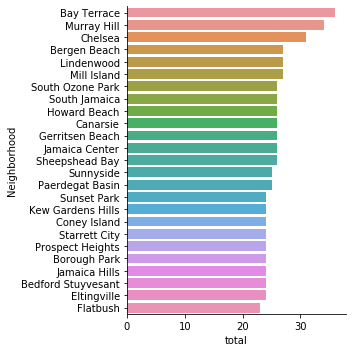

In [162]:
sns.catplot(x='total', y='Neighborhood', data=venue_counts_25, kind='bar')

#### distribution plot of total venues in all neighborhoods

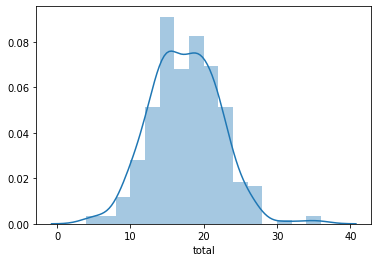

In [168]:
sns.distplot(venue_counts['total']);

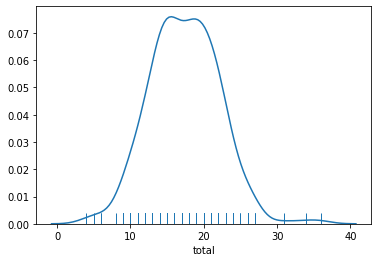

In [170]:
sns.distplot(venue_counts['total'], hist=False, rug=True);

#### determine amount of venues of each category

In [178]:
venue_totals = {}
for category in nightlife_related_categories:
    if category in venue_counts.columns:
        venue_totals[category] = venue_counts[category].sum()
    

venue_totals_sorted = sorted(venue_totals.items(), key=lambda x: x[1],reverse=True)
venue_totals_sorted

[('Cocktail Bar', 907),
 ('Lounge', 692),
 ('Brewery', 563),
 ('Sports Bar', 528),
 ('Beer Garden', 455),
 ('Beer Bar', 420),
 ('Nightclub', 367),
 ('Wine Bar', 330),
 ('Other Nightlife', 293),
 ('Dive Bar', 235),
 ('Karaoke Bar', 214),
 ('Hookah Bar', 156),
 ('Beach Bar', 35),
 ('Whisky Bar', 34),
 ('Strip Club', 18),
 ('Night Market', 8)]

#### For each venue category, determine the percentage of entities in each neighborhood

In [179]:
venue_mean = pd.DataFrame()
for category, total in venue_totals.items():
    venue_mean[category] = venue_counts[category].apply(lambda x: x / total)
venue_mean = venue_mean.reindex(sorted(venue_mean.columns), axis=1).reset_index()
venue_mean.head(5)

,Neighborhood,Beach Bar,Beer Bar,Beer Garden,Brewery,Cocktail Bar,Dive Bar,Hookah Bar,Karaoke Bar,Lounge,Night Market,Nightclub,Other Nightlife,Sports Bar,Strip Club,Whisky Bar,Wine Bar
0,Allerton,0.0,0.004762,0.002198,0.001776,0.002205,0.000000,0.00000,0.0,0.004335,0.0,0.00000,0.006826,0.003788,0.000000,0.0,0.006061
1,Annadale,0.0,0.000000,0.004396,0.000000,0.001103,0.004255,0.00641,0.0,0.007225,0.0,0.00545,0.017065,0.007576,0.055556,0.0,0.000000
2,Arden Heights,0.0,0.000000,0.004396,0.000000,0.001103,0.000000,0.00641,0.0,0.004335,0.0,0.00545,0.010239,0.007576,0.000000,0.0,0.003030
3,Arlington,0.0,0.000000,0.002198,0.000000,0.002205,0.000000,0.00000,0.0,0.000000,0.0,0.00000,0.000000,0.003788,0.000000,0.0,0.003030
4,Arrochar,0.0,0.002381,0.006593,0.003552,0.004410,0.000000,0.00641,0.0,0.000000,0.0,0.00000,0.003413,0.005682,0.000000,0.0,0.000000


#### Creating a dataframe that shows top 5 venue categories each neighborhood is known for

In [183]:
def return_top_venue_categories(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [197]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Top Venue Category'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Top Venue Category'.format(ind+1))

neighborhoods_top_venue_categories = pd.DataFrame(columns=columns)
neighborhoods_top_venue_categories['Neighborhood'] = venue_mean['Neighborhood']

for ind in np.arange(venue_mean.shape[0]):
    neighborhoods_top_venue_categories.iloc[ind, 1:] = return_top_venue_categories(venue_mean.iloc[ind, :], num_top_venues)

neighborhoods_top_venue_categories.head(5)

,Neighborhood,1st Top Venue Category,2nd Top Venue Category,3rd Top Venue Category,4th Top Venue Category,5th Top Venue Category
0,Allerton,Other Nightlife,Wine Bar,Beer Bar,Lounge,Sports Bar
1,Annadale,Strip Club,Other Nightlife,Sports Bar,Lounge,Hookah Bar
2,Arden Heights,Other Nightlife,Sports Bar,Hookah Bar,Nightclub,Beer Garden
3,Arlington,Sports Bar,Wine Bar,Cocktail Bar,Beer Garden,Whisky Bar
4,Arrochar,Beer Garden,Hookah Bar,Sports Bar,Cocktail Bar,Brewery


## Create KMeans Model To Cluster Neighborhoods

In [198]:
venue_grouped_clustering = venue_mean.drop('Neighborhood', 1) 

#### finding the right clustering k 

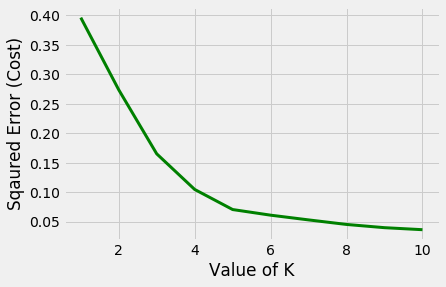

In [199]:

cost =[] 
for i in range(1, 11): 
    KM = KMeans(n_clusters = i, max_iter = 500) 
    KM.fit(venue_grouped_clustering) 
      
    # calculates squared error 
    # for the clustered points 
    cost.append(KM.inertia_)      
  
# plot the cost against K values 
plt.plot(range(1, 11), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show() # clear the plot 

In [200]:
kclusters = 8
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(venue_grouped_clustering)

kmeans.labels_

array([5, 4, 5, 0, 5, 2, 0, 0, 3, 0, 0, 0, 3, 5, 3, 7, 5, 0, 3, 5, 2, 5,
       6, 0, 5, 0, 5, 0, 0, 7, 3, 5, 7, 0, 5, 0, 5, 0, 5, 0, 4, 5, 5, 0,
       0, 4, 0, 0, 5, 5, 0, 6, 0, 0, 0, 5, 5, 0, 0, 5, 0, 3, 5, 0, 0, 5,
       0, 5, 1, 0, 0, 5, 5, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 5, 5, 7, 4, 5,
       5, 6, 4, 5, 0, 7, 0, 0, 0, 0, 0, 5, 3, 6, 3, 0, 0, 5, 5, 3, 0, 0,
       5, 5, 0, 0, 0, 5, 5, 5, 5, 5, 0, 5, 0, 5, 0, 7, 5, 0, 0, 3, 6, 6,
       5, 5, 0, 0, 4, 0, 5, 0, 6, 6, 6, 1, 0, 6, 3, 0, 6, 5, 0, 0, 5, 0,
       0, 0, 5, 0, 5, 0, 0, 3, 5, 0, 0, 0, 5, 6, 5, 0, 1, 0, 0, 5, 0, 0,
       0, 0, 5, 0, 0, 4, 5, 0, 0, 0, 3, 2, 5, 5, 5, 0, 5, 0, 5, 0, 0, 5,
       6, 5, 1, 0, 5, 5, 0, 0, 5, 0, 4, 5, 5, 4, 5, 3, 0, 0, 0, 4, 0, 0,
       0, 5, 3, 0, 5, 0, 0, 4, 0, 6, 5, 5, 1, 0, 5, 2, 2, 0, 5, 5, 5, 7,
       0, 5, 4, 5, 5, 5, 5, 0, 7, 5, 5, 1, 1, 0, 5, 0, 5, 5, 0, 0, 0, 0,
       0, 0, 0, 0, 4, 5, 0, 5, 5, 0, 0, 0, 4, 0, 0, 0, 3, 5, 0, 5, 0, 1,
       5, 6, 0, 4, 0, 3, 5, 0, 5, 0, 0, 0, 5, 4, 0,

#### Creating a new dataframe merging neighborhood location data, top venue category by neighborhood, and cluster labels

In [201]:
neighborhoods_top_venue_categories.insert(1,'Cluster Labels', kmeans.labels_)

ny_neighborhood_music_profile = nyc_neighborhoods.drop(columns=['Borough'])

ny_neighborhood_music_profile = ny_neighborhood_music_profile.join(neighborhoods_top_venue_categories.set_index('Neighborhood'), on='Neighborhood').dropna(axis=0)

ny_neighborhood_music_profile.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Top Venue Category,2nd Top Venue Category,3rd Top Venue Category,4th Top Venue Category,5th Top Venue Category
0,Wakefield,40.894705,-73.847201,5,Other Nightlife,Lounge,Beer Bar,Sports Bar,Beer Garden
1,Co-op City,40.874294,-73.829939,5,Other Nightlife,Lounge,Brewery,Nightclub,Beer Bar
2,Eastchester,40.887556,-73.827806,5,Other Nightlife,Lounge,Brewery,Beer Bar,Beer Garden
3,Fieldston,40.895437,-73.905643,0,Wine Bar,Beer Bar,Lounge,Sports Bar,Brewery
4,Riverdale,40.890834,-73.912585,0,Beer Bar,Wine Bar,Sports Bar,Brewery,Other Nightlife


#### Creating a Visualisation of the clusters

In [202]:
# create map
import matplotlib.cm as cm
import matplotlib.colors as colors
latitude = 40.730610
longitude = -73.935242
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ny_neighborhood_music_profile['Latitude'], ny_neighborhood_music_profile['Longitude'], ny_neighborhood_music_profile['Neighborhood'], ny_neighborhood_music_profile['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examining Clusters

In [203]:
for cluster in range(0, kclusters):
    print(f'Cluster {cluster}:')
    print(ny_neighborhood_music_profile.loc[ny_neighborhood_music_profile['Cluster Labels'] == cluster, ny_neighborhood_music_profile.columns[[0] + list(range(4, ny_neighborhood_music_profile.shape[1]))]], end="\n\n\n")

Cluster 0:
           Neighborhood 1st Top Venue Category 2nd Top Venue Category  \
3             Fieldston               Wine Bar               Beer Bar   
4             Riverdale               Beer Bar               Wine Bar   
5           Kingsbridge             Sports Bar               Beer Bar   
14   University Heights               Beer Bar             Sports Bar   
15       Morris Heights               Beer Bar               Wine Bar   
..                  ...                    ...                    ...   
295       Highland Park               Dive Bar              Nightclub   
296             Madison                 Lounge           Cocktail Bar   
300             Erasmus                Brewery               Beer Bar   
301        Hudson Yards           Cocktail Bar              Nightclub   
304        Queensbridge           Cocktail Bar               Beer Bar   

    3rd Top Venue Category 4th Top Venue Category 5th Top Venue Category  
3                   Lounge           

In [1]:
cluster=0
print(f'Cluster {cluster}:')
print(ny_neighborhood_music_profile.loc[ny_neighborhood_music_profile['Cluster Labels'] == cluster, ny_neighborhood_music_profile.columns[[0] + list(range(4, ny_neighborhood_music_profile.shape[1]))]], end="\n\n\n")

Cluster 0:


NameError: name 'ny_neighborhood_music_profile' is not defined